In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

### Environment

In [2]:
class GridWorld:
    def __init__(self):
        self.x = 0
        self.y = 0

    def step(self, a):
        if a == 0:
            self.move_right()
        elif a == 1:
            self.move_left()
        elif a == 2:
            self.move_up()
        elif a == 3:
            self.move_down()

        reward = -1
        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_right(self):
        self.y += 1
        if self.y > 3:
            self.y = 3

    def move_left(self):
        self.y -= 1
        if self.y < 0:
            self.y = 0

    def move_up(self):
        self.x -= 1
        if self.x < 0:
            self.x = 0

    def move_down(self):
        self.x += 1
        if self.x > 3:
            self.x = 3

    def is_done(self):
        if self.x == 3 and self.y == 3:
            return True
        else:
            return False

    def get_state(self):
        return (self.x, self.y)

    def reset(self):
        self.x = 0
        self.y = 0
        return (self.x, self.y)


### Agent

In [3]:
class Agent:
    def __init__(self):
        pass

    def select_action(self):
        coin = random.random()
        if coin < 0.25:
            action = 0
        elif coin < 0.5:
            action = 1
        elif coin < 0.75:
            action = 2
        else:
            action = 3
        return action

### MC

In [4]:
def MC_evaluation(gamma: float = 1.0, alpha: float = 0.001, num_episodes: int = 50000):
    env = GridWorld()
    agent = Agent()
    V = np.zeros((4, 4), dtype=float)
    
    for episode in tqdm(range(num_episodes)):
        env.reset()
        state = env.get_state()
        done = False
        trajectory = []
        while not done:
            action = agent.select_action()
            next_state, reward, done = env.step(action)
            trajectory.append((state, reward))
            state = next_state

        G = 0
        for transition in trajectory[::-1]:
            state, reward = transition
            G = reward + gamma * G
            V[state] += alpha * (G - V[state])

    return V


### One-step TD

In [5]:
def One_Step_TD_evaluation(gamma: float = 1.0, alpha: float = 0.001, num_episodes: int = 50000):
    env = GridWorld()
    agent = Agent()
    V = np.zeros((4, 4), dtype=float)
    
    for episode in tqdm(range(num_episodes)):
        env.reset()
        state = env.get_state()
        done = False
        while not done:
            action = agent.select_action()
            next_state, reward, done = env.step(action)
            V[state] = V[state] + alpha * (reward + gamma * V[next_state] - V[state])
            state = next_state
    return V

### N-step TD

In [6]:
def N_Step_TD_evaluation(n: int, gamma: float = 1.0, alpha: float = 0.001, num_episodes: int = 50000):
    env = GridWorld()
    agent = Agent()
    V = np.zeros((4, 4), dtype=float)
    
    for episode in tqdm(range(num_episodes)):
        env.reset()
        state = env.get_state()
        done = False
        trajectory = []
        trajectory.append((state, 0))
        T = np.inf
        t = 0
        
        while True:
            if t < T:
                action = agent.select_action()
                next_state, reward, done = env.step(action)
                trajectory.append((state, reward))
                
                if done:
                    T = t + 1
                else:
                    state = next_state
                
            tau = t - n + 1
            if tau >= 0:
                G = 0
                for i in range(tau + 1, min(tau + n + 1, T + 1)):
                    G += np.power(gamma, i - tau - 1) * trajectory[i - 1][1]
                if tau + n < T:
                    G += np.power(gamma, n) * V[trajectory[tau + n][0]]
                V[trajectory[tau][0]] += alpha * (G - V[trajectory[tau][0]])
            if tau == T - 1:
                break
            
            t += 1
    return V

### Visualization

In [7]:
from matplotlib.colors import LinearSegmentedColormap

def visualize_with_titles(data_dict):
    plt.figure(figsize=(18, 12))
    custom_cmap = LinearSegmentedColormap.from_list("red_white", ["red", "white"], N=256)

    for i, (title, data) in enumerate(data_dict.items(), start=1):
        plt.subplot(2, 4, i)
        sns.heatmap(data, annot=True, fmt=".2f", cmap=custom_cmap, cbar=False)
        plt.title(title)

    plt.tight_layout()
    plt.show()

100%|██████████| 50000/50000 [00:19<00:00, 2578.81it/s]


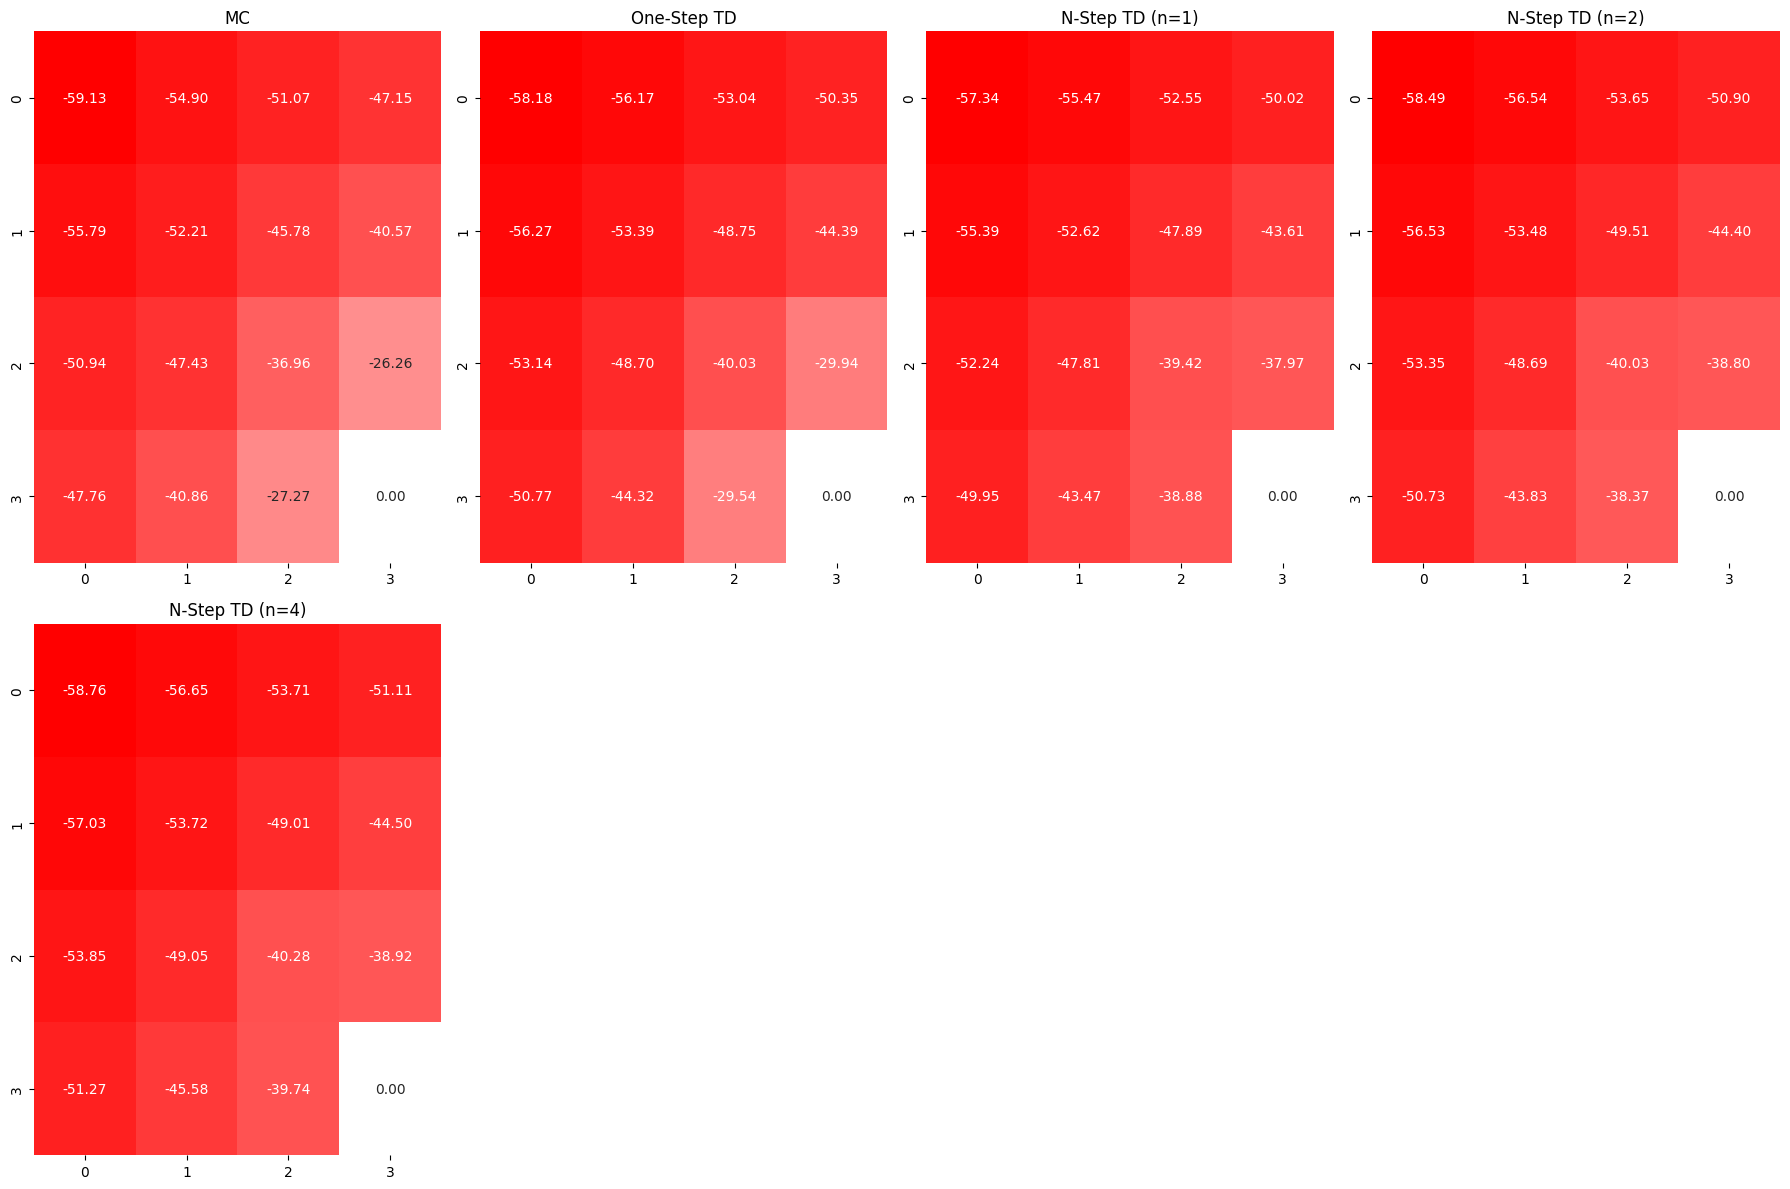

In [8]:
data_dict = {}
data_dict["MC"] = MC_evaluation()
data_dict["One-Step TD"] = One_Step_TD_evaluation()
data_dict["N-Step TD (n=1)"] = N_Step_TD_evaluation(n=1)
data_dict["N-Step TD (n=2)"] = N_Step_TD_evaluation(n=2)
data_dict["N-Step TD (n=4)"] = N_Step_TD_evaluation(n=4)

visualize_with_titles(data_dict)

In [11]:
print("MC:", data_dict["MC"])
print("One-Step TD:", data_dict["One-Step TD"])
print("TD(1):", data_dict["N-Step TD (n=1)"])
print("TD(2):", data_dict["N-Step TD (n=2)"])
print("TD(4):", data_dict["N-Step TD (n=4)"])

MC: [[-59.12761133 -54.89851364 -51.07365865 -47.14749931]
 [-55.79418912 -52.20792704 -45.78472691 -40.57296289]
 [-50.93803538 -47.42919311 -36.96141192 -26.2554926 ]
 [-47.76266792 -40.85562195 -27.27019385   0.        ]]
One-Step TD: [[-58.18232394 -56.16632808 -53.03710488 -50.35447395]
 [-56.26961428 -53.38719461 -48.74755327 -44.38811917]
 [-53.14400215 -48.69591382 -40.02519257 -29.94102607]
 [-50.77129884 -44.32092245 -29.53922135   0.        ]]
TD(1): [[-57.3403545  -55.46543959 -52.5549107  -50.02387055]
 [-55.38646325 -52.62069663 -47.89333345 -43.60678092]
 [-52.23810496 -47.81356942 -39.42322054 -37.96839479]
 [-49.95074444 -43.46764166 -38.87520046   0.        ]]
TD(2): [[-58.48949457 -56.54336755 -53.65208744 -50.89914719]
 [-56.53265281 -53.48028764 -49.51104549 -44.40395395]
 [-53.34888529 -48.68725879 -40.03225379 -38.80276069]
 [-50.72583043 -43.83337766 -38.37041167   0.        ]]
TD(4): [[-58.75800895 -56.64985844 -53.71261866 -51.10544741]
 [-57.02937733 -53.7212